In [1]:
import pyarrow.parquet as pq

In [2]:
import numpy as np
import pandas as pd

In [3]:
import pandas as pd
import os
from tqdm import tqdm

# Define the folder path
folder_path = "data/stablecoins/stablecoins_txs_0_19250000/USDT/"

# List all files in the folder with .parquet extension
parquet_files = [f for f in os.listdir(folder_path) if f.endswith('.parquet')]

# Initialize an empty list to store DataFrames
dataframes = []

# Iterate through the files and read them into DataFrames
for file in tqdm(parquet_files):
    file_path = os.path.join(folder_path, file)
    df = pd.read_parquet(file_path)
    dataframes.append(df)

# Merge all DataFrames into one
merged_df = pd.concat(dataframes, ignore_index=True)

merged_df.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [01:36<00:00,  2.83s/it]


,blockNumber,from,to,fromIsContract,toIsContract,value
0,15750000,0xc9cd0f6977aaafcc936e519771abb0e6bdd76c04,0xf5dce915d9cf275d9fa2f78b835f6291d642a894,0,0,50000000
1,15750000,0x5041ed759dd4afc3a72b8192c143f72f4724081a,0x58b8a25dc105f0c265f919b7138a02b2de93da93,0,0,2000000
2,15750000,0x5041ed759dd4afc3a72b8192c143f72f4724081a,0x0d91dd0f5a1d603e08a922537ec02ca66dfee634,0,0,200000000
3,15750000,0x5041ed759dd4afc3a72b8192c143f72f4724081a,0x5f2ee554502aa4e45ba87c99bf7d36cbeeed231c,0,0,206856400
4,15750000,0x2faf487a4414fe77e2327f0bf4ae2a264a776ad2,0xaac4cb440047440b26e2ff5de6154e5549848d38,0,0,499500000


In [4]:
df = merged_df

# Step 1: Convert 'from' and 'to' columns into integers
# Create a mapping of unique strings to integers
unique_addresses = pd.concat([df['from'], df['to']]).unique()
address_map = {address: i for i, address in enumerate(unique_addresses)}

# Map the columns
df['from'] = df['from'].map(address_map)
df['to'] = df['to'].map(address_map)

In [5]:
import pickle
with open('data/stablecoins/USDT_address_map.pickle', 'wb') as handle:
    pickle.dump(address_map, handle)

In [5]:
df.value = pd.to_numeric(df['value'])

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227688979 entries, 0 to 227688978
Data columns (total 6 columns):
 #   Column          Dtype
---  ------          -----
 0   blockNumber     int64
 1   from            int64
 2   to              int64
 3   fromIsContract  int64
 4   toIsContract    int64
 5   value           int64
dtypes: int64(6)
memory usage: 10.2 GB


In [7]:
# Step 2: Calculate balances
# Create a transaction DataFrame with positive values for 'to' and negative for 'from'
transactions = pd.concat([
    df[['blockNumber', 'to', 'value']].rename(columns={'to': 'account', 'value': 'balance_change'}),
    df[['blockNumber', 'from', 'value']].rename(columns={'from': 'account', 'value': 'balance_change'})
], ignore_index=True)
transactions.loc[transactions.index >= len(df), 'balance_change'] *= -1



In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455377958 entries, 0 to 455377957
Data columns (total 3 columns):
 #   Column          Dtype
---  ------          -----
 0   blockNumber     int64
 1   account         int64
 2   balance_change  int64
dtypes: int64(3)
memory usage: 10.2 GB


In [13]:
transactions.balance_change.sum()

0

In [11]:
# Sort by blockNumber and account
transactions.sort_values(['blockNumber', 'account'], inplace=True)
print("sorted")

# Calculate cumulative balance
transactions['cumulative_balance'] = transactions.groupby('account')['balance_change'].cumsum()
print("cumulative balances calculated")

# Result: Balances for each account
balances = transactions.groupby('account')['cumulative_balance'].last().reset_index()
print("final balances created")

# Map back to original string addresses for clarity (optional)
balances['account'] = balances['account'].map({v: k for k, v in address_map.items()})
print("id -> string done")

sorted
cumulative balances calculated
final balances created
id -> string done


In [16]:
asd = transactions.loc[transactions['cumulative_balance'] < 0]
asd.account.unique()

array([16839943,  3425078])

In [16]:
balances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36105030 entries, 0 to 36105029
Data columns (total 2 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   account             object
 1   cumulative_balance  int64 
dtypes: int64(1), object(1)
memory usage: 550.9+ MB


In [23]:
balances[balances.account == "0xdac17f958d2ee523a2206206994597c13d831ec7"]

,account,cumulative_balance
30894137,0xdac17f958d2ee523a2206206994597c13d831ec7,16478293352749


In [19]:
balances[balances.cumulative_balance < 0].cumulative_balance.sum()

-44210006881104645

In [22]:
balances[balances.cumulative_balance < 0]

,account,cumulative_balance
3425078,0xc6cde7c39eb2f0f0095f41570af89efc2c1ea828,-44209909021875010
16839943,0x36928500bc1dcd7af6a2b4008875cc336b927d57,-97859229635


In [6]:
USDT_known_addresses = {'null':'0x0000000000000000000000000000000000000000',
                        'mintburn':'0xc6cde7c39eb2f0f0095f41570af89efc2c1ea828',
                        'deployer':'0x36928500bc1dcd7af6a2b4008875cc336b927d57',
                        'treasury':str.lower('0x5754284f345afc66a98fbB0a0Afe71e0F007B949'),
                        'contract':'0xdac17f958d2ee523a2206206994597c13d831ec7'}

In [7]:
df['is_mint'] = ((df['from'].isin([address_map[USDT_known_addresses['mintburn']], address_map[USDT_known_addresses['null']]])))

In [8]:
df['is_burn'] = (df['to'].isin([address_map[USDT_known_addresses['null']], address_map[USDT_known_addresses['mintburn']]])
                & (~df['from'].isin(address_map[v] for k,v in USDT_known_addresses.items())))

In [9]:
allocations = df[((df['is_burn']==True) | (df['is_mint']==True))]

In [10]:
allocations.head()

,blockNumber,from,to,fromIsContract,toIsContract,value,is_mint,is_burn
385346,15780594,131640,30899450,0,0,13000000,False,True
1162201,15833391,333101,30899450,0,0,603895065,False,True
1278727,15840971,333101,30899450,0,0,394824960,False,True
1353478,15846294,333101,30899450,0,0,1225645464,False,True
1363405,15846842,333101,30899450,0,0,818610178,False,True


In [11]:
allocations.loc[df["is_burn"], "value"] *= -1

In [12]:
allocations.head()

,blockNumber,from,to,fromIsContract,toIsContract,value,is_mint,is_burn
385346,15780594,131640,30899450,0,0,-13000000,False,True
1162201,15833391,333101,30899450,0,0,-603895065,False,True
1278727,15840971,333101,30899450,0,0,-394824960,False,True
1353478,15846294,333101,30899450,0,0,-1225645464,False,True
1363405,15846842,333101,30899450,0,0,-818610178,False,True


In [13]:
sorted_alloc = allocations.sort_values(by="blockNumber", ascending=True)

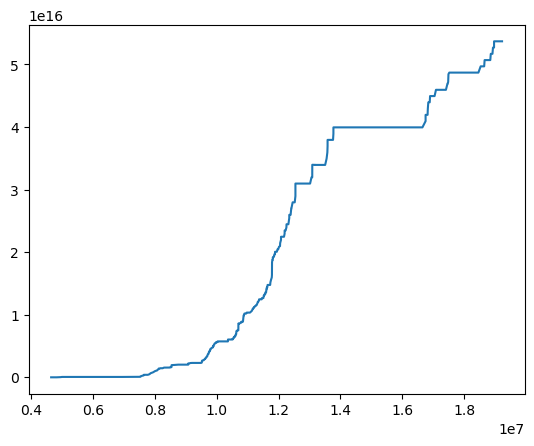

In [14]:
import matplotlib.pyplot as plt

plt.plot(sorted_alloc.blockNumber, sorted_alloc.value.cumsum())
#plt.yscale('log')

In [15]:
select_alloc = sorted_alloc[['to', 'value', 'blockNumber']]

In [16]:
renamed_alloc = select_alloc.rename(columns={'to':'to_address','value':'amount','blockNumber':'block_number'})

In [17]:
renamed_alloc.head()

,to_address,amount,block_number
106154283,16839944,10000000,4638577
106154285,16839944,10000000,4638663
106154287,16839944,10000000,4638705
106154289,16839944,100000000,4638894
106154291,14650020,20000000,4773369


In [18]:
renamed_alloc.to_csv("data/stablecoins/USDT_allocation.csv", index=False)

In [19]:
transfers = df[((df['is_burn']==False) & (df['is_mint']==False))]

In [20]:
sorted_transfers = transfers.sort_values(by="blockNumber", ascending=True)

In [21]:
sorted_transfers.head()

,blockNumber,from,to,fromIsContract,toIsContract,value,is_mint,is_burn
106154282,4638568,16839943,3425078,0,1,100000000,False,False
106154284,4638586,16839943,3425078,0,1,99900000000,False,False
106154286,4638700,16839944,23444920,0,0,20000000,False,False
106154288,4638713,16839944,23444920,0,0,10000000,False,False
106154290,4638924,16839944,23444920,0,0,100000000,False,False


In [22]:
select_transf = sorted_transfers[['from','to','value','blockNumber']]

In [23]:
renamed_transf = select_transf.rename(columns={'from':'from_address','to':'to_address','value':'amount','blockNumber':'block_number'})

In [24]:
renamed_transf.head()

,from_address,to_address,amount,block_number
106154282,16839943,3425078,100000000,4638568
106154284,16839943,3425078,99900000000,4638586
106154286,16839944,23444920,20000000,4638700
106154288,16839944,23444920,10000000,4638713
106154290,16839944,23444920,100000000,4638924


In [25]:
renamed_transf.to_csv("data/stablecoins/USDT_transfer.csv", index=False)

In [91]:
renamed_transf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227684082 entries, 106154282 to 126830351
Data columns (total 4 columns):
 #   Column        Dtype
---  ------        -----
 0   from_address  int64
 1   to_address    int64
 2   amount        int64
 3   block_number  int64
dtypes: int64(4)
memory usage: 8.5 GB
